## Imports

In [4]:
import os
import numpy as np 
import pandas as pd
from tqdm import tqdm

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## Industry Analysis

In [5]:
ROOT='./kaggle/input/dt23-test/'

directory_path = ROOT + 'series/adjusted_close_per_industry'
all_files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f)) and f.endswith('.csv')]

def daily_percentage_return(df):
    return df.pct_change().dropna()

## Correlation Cycle

In [ ]:
industry_correlations = {}

for file in all_files:
    industry_df = pd.read_csv(os.path.join(directory_path, file))
    industry_df['timestamp'] = pd.to_datetime(industry_df['timestamp'])
    industry_df.set_index('timestamp', inplace=True)
    
    # Calculate the daily percentage return for the industry and SPY
    industry_daily_return = daily_percentage_return(industry_df.drop(columns=['adjusted_close_SPY500'])).mean(axis=1)
    spy_daily_return = daily_percentage_return(industry_df['adjusted_close_SPY500'])

    # Separate into green days and red days for SPY
    green_days = industry_daily_return[spy_daily_return > 0]
    red_days = industry_daily_return[spy_daily_return <= 0]

    # Calculate the correlation coefficients
    green_correlation = green_days.corr(spy_daily_return[spy_daily_return > 0])
    red_correlation = red_days.corr(spy_daily_return[spy_daily_return <= 0])

    # Save the correlation coefficients to the dictionary
    industry_correlations[file] = {'green_correlation': green_correlation, 'red_correlation': red_correlation}

correlation_df = pd.DataFrame.from_dict(industry_correlations, orient='index')

## Discrimination Cycle

In [ ]:
def select_industries(correlation_df):
    # Fit the linear model
    X = correlation_df['green_correlation'].values.reshape(-1, 1)
    y = correlation_df['red_correlation'].values
    model = LinearRegression().fit(X, y)
    
    # Get the predicted y values from the model
    predicted = model.predict(X)
    
    # Calculate the residuals (actual - predicted)
    correlation_df['residuals'] = y - predicted
    
    # Add a column for the distance from the line (negative residuals are below the line)
    correlation_df['distance_from_fit'] = -correlation_df['residuals']
    
    # Select industries with the highest green_day beta that are furthest below the linear fit
    selected_industries = correlation_df[correlation_df['distance_from_fit'] > 0.01].sort_values(by=['green_correlation', 'distance_from_fit'], ascending=[False, False])
    
    return selected_industries

# Call the function with your correlation_df
selected_industries = select_industries(correlation_df)

## Weighing

In [7]:
def rand_weights(returns,*args,**kwargs):
    """
        Produces random weights for num_to_select assets 
    """
    # The following array will be True for all products i that are available
    product_availability_mask = ~returns.iloc[-1].isna().values
    
    # The following array will contain all the indices i of available products
    available_product_indices = np.nonzero(product_availability_mask)[0]
    
    weights = np.zeros(len(returns.T))
    num_to_select = 125
    
    # Generate unique random indices within the array size
    random_indices = np.random.choice(available_product_indices, num_to_select, replace=False)

    # Create a boolean mask based on the randomly selected indices
    mask = np.zeros(len(weights), dtype=bool)
    mask[random_indices] = True
    rw = np.random.rand(sum(mask))
    rw /= sum(rw)
    weights[mask]=rw
    return pd.Series({"weight_"+a.split('_')[-1]:b for a,b in zip(returns.columns,weights)})

    

## Cummulative Growth

In [ ]:
adjusted_close_df = pd.read_csv(ROOT+'series/adjusted_close.csv',index_col=0)
adjusted_close_df.index = pd.to_datetime(adjusted_close_df.index)
adjusted_close_df = adjusted_close_df.sort_index(ascending=True).replace([np.inf, -np.inf], np.nan).interpolate(method='linear').fillna(0)

            percentage_variation_CSCO  percentage_variation_ISRG  \
timestamp                                                          
1999-11-01                   0.000000                        0.0   
1999-11-02                   0.850714                        0.0   
1999-11-03                  -2.721088                        0.0   
1999-11-04                  -2.097902                        0.0   
1999-11-05                   4.914286                        0.0   

            percentage_variation_TPR  
timestamp                             
1999-11-01                       0.0  
1999-11-02                       0.0  
1999-11-03                       0.0  
1999-11-04                       0.0  
1999-11-05                       0.0  
            adjusted_close_CSCO  adjusted_close_ISRG  adjusted_close_TPR
timestamp                                                               
1999-11-01            25.121693                  0.0                 0.0
1999-11-02            25.335406

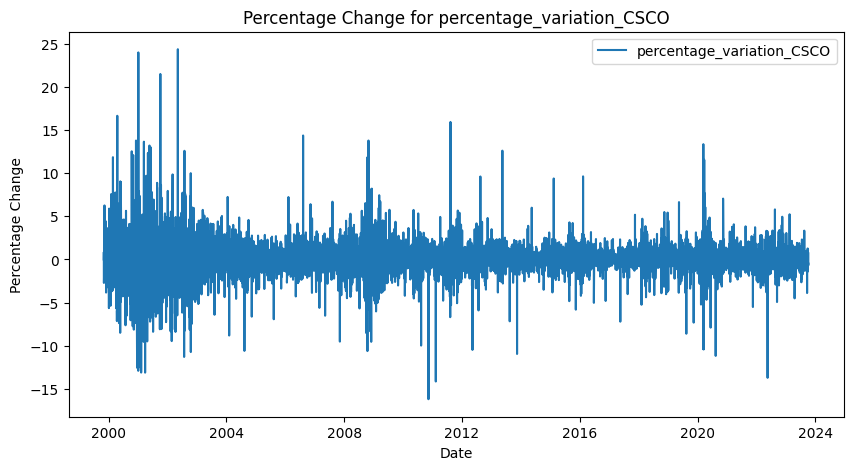

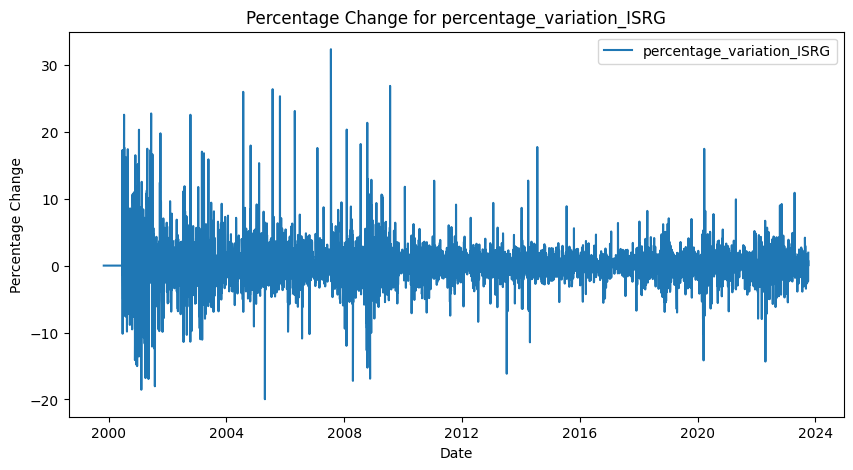

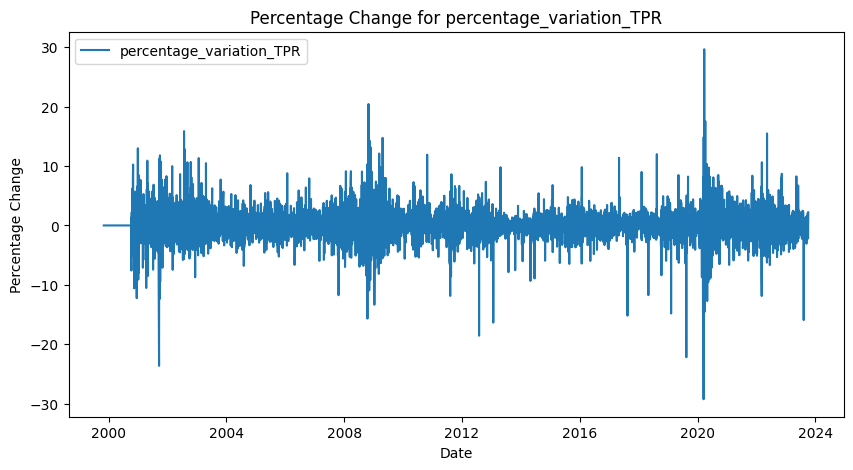

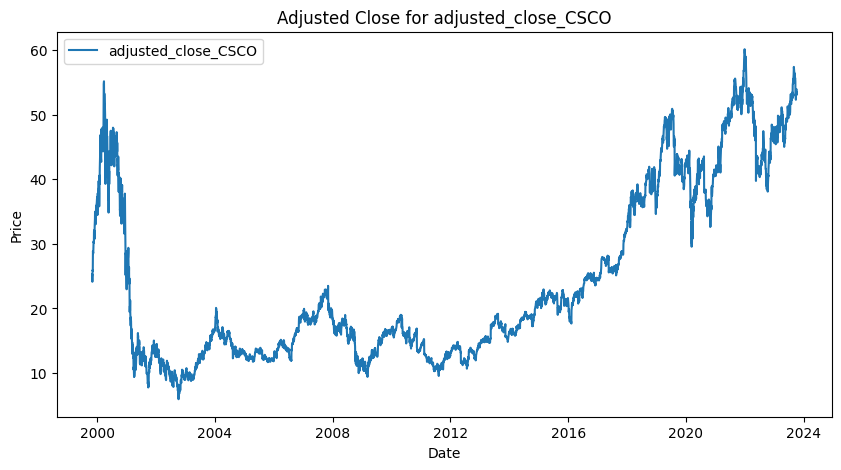

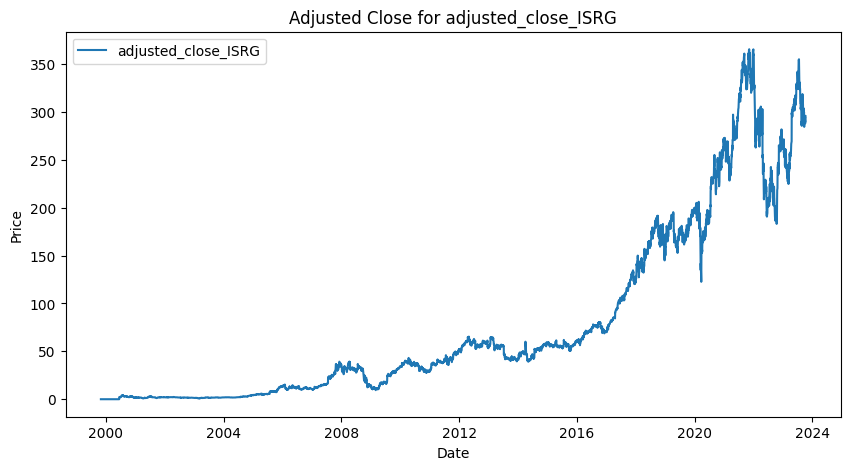

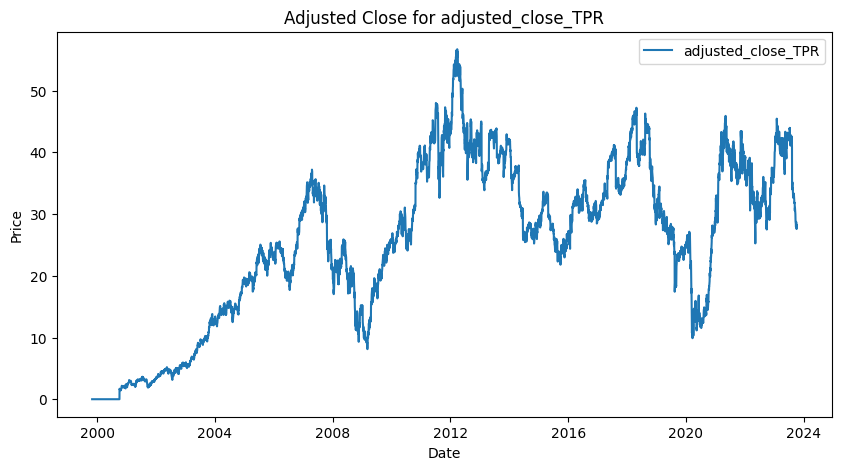

In [ ]:

adjusted_close_df['daily_sum'] = adjusted_close_df.sum(axis=1)
# close_df['daily_sum'] = close_df.sum(axis=1)

adjusted_close_df.head()

# Calculate percentage change
percentage_returns_df = adjusted_close_df.pct_change() * 100
# Replace inf values with 0 in the resulting DataFrame
percentage_returns_df.replace([np.inf, -np.inf], 0, inplace=True)

# Rename columns by replacing 'adjusted_close' with 'percentage_variation'
percentage_returns_df.columns = percentage_returns_df.columns.str.replace('adjusted_close', 'percentage_variation')

# Fill missing values in percentage_returns_df using linear interpolation
percentage_returns_df = percentage_returns_df.fillna(0)

# Print the first 3 columns of percentage_returns_df
print(percentage_returns_df.iloc[:, :3].head())

# Print the first 3 columns of adjusted_close_df
print(adjusted_close_df.iloc[:, :3].head())

# Create separate plots for the first 3 columns of percentage_returns_df
# for col in percentage_returns_df.columns[:3]:
#     plt.figure(figsize=(10, 5))
#     plt.plot(percentage_returns_df.index, percentage_returns_df[col], label=col)
#     plt.title(f'Percentage Change for {col}')
#     plt.xlabel('Date')
#     plt.ylabel('Percentage Change')
#     plt.legend()
#     plt.show()

# Create separate plots for the first 3 columns of adjusted_close_df
# for col in adjusted_close_df.columns[:3]:
#     plt.figure(figsize=(10, 5))
#     plt.plot(adjusted_close_df.index, adjusted_close_df[col], label=col)
#     plt.title(f'Adjusted Close for {col}')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.legend()
#     plt.show()


            Unnamed: 0        open        high         low       close  \
timestamp                                                                
1999-11-01        6031  136.500000  137.000000  135.562500  135.562500   
1999-11-02        6030  135.968704  137.250000  134.593704  134.593704   
1999-11-03        6029  136.000000  136.375000  135.125000  135.500000   
1999-11-04        6028  136.750000  137.359299  135.765594  136.531204   
1999-11-05        6027  138.625000  139.109299  136.781204  137.875000   

            adjusted_close   volume  dividend  split  percentage_variation  
timestamp                                                                   
1999-11-01       87.576805  4006500       0.0    1.0              0.000000  
1999-11-02       86.950938  6516900       0.0    1.0             -0.714649  
1999-11-03       87.536428  7222300       0.0    1.0              0.673357  
1999-11-04       88.202612  7907500       0.0    1.0              0.761036  
1999-11-05       89

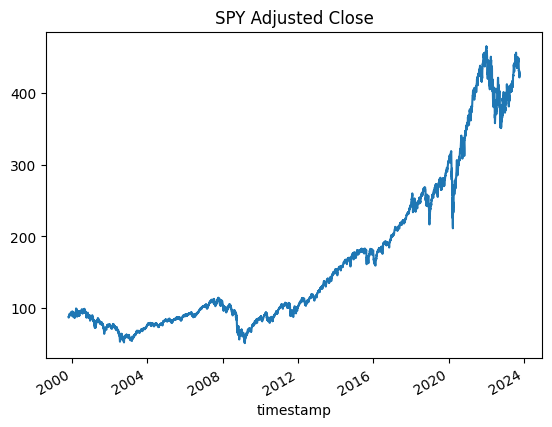

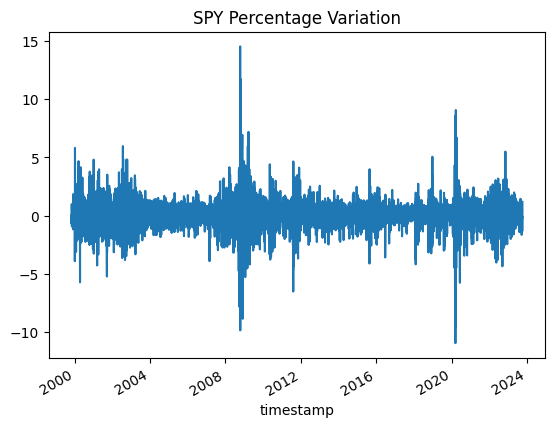

In [ ]:
# data for SPY500 stock
spy_df = pd.read_csv(ROOT + '/series/benchmark/SPY.csv')
spy_df['timestamp'] = pd.to_datetime(spy_df['timestamp'])  # Convert 'timestamp' to datetime
spy_df.set_index('timestamp', inplace=True)
spy_df = spy_df.sort_index(ascending=True)
spy_df.interpolate(method='linear',inplace=True)

# The column names should be in quotes to be recognized as strings
spy_df.drop(columns=spy_df.columns.difference(['adjusted_close']))
# Assuming percentage_returns_df is another DataFrame indexed by dates
# Find common dates in spy_df and percentage_returns_df
common_dates = spy_df.index.intersection(percentage_returns_df.index)

# Keep only the rows with common dates
spy_df = spy_df.loc[common_dates]

# Calculate the percentage change for the adjusted_close in spy_df
spy_df['percentage_variation'] = spy_df['adjusted_close'].pct_change() * 100
spy_df.fillna(0,inplace=True)
print(spy_df.head())
# Plot the adjusted close
spy_df['adjusted_close'].plot(title='SPY Adjusted Close')
plt.show()

# Plot the percentage variation
spy_df['percentage_variation'].plot(title='SPY Percentage Variation')
plt.show()

In [ ]:
percentage_returns_df['percentage_variation_SPY500'] = spy_df['percentage_variation']
adjusted_close_df['adjusted_close_SPY500'] = spy_df['adjusted_close']

print(percentage_returns_df.tail())
print(adjusted_close_df.head())

            percentage_variation_CSCO  percentage_variation_ISRG  \
timestamp                                                          
2023-10-02                   1.171875                   0.920319   
2023-10-03                  -0.643501                  -2.352702   
2023-10-04                  -0.372787                   0.777670   
2023-10-05                  -0.710945                  -0.065454   
2023-10-06                   0.716035                   1.926988   

            percentage_variation_TPR  percentage_variation_DVN  \
timestamp                                                        
2023-10-02                 -0.591304                 -4.297694   
2023-10-03                 -2.204339                  0.219058   
2023-10-04                 -0.393560                 -5.245902   
2023-10-05                 -0.933908                 -1.153403   
2023-10-06                  2.211748                  1.983664   

            percentage_variation_MRO  percentage_variation_B

In [ ]:
def calculate_cumulative_growth(percentage_df):
    """
    Takes a DataFrame with percentage changes and calculates the cumulative growth.

    Args:
    percentage_df (pd.DataFrame): DataFrame containing percentage changes.

    Returns:
    pd.DataFrame: DataFrame containing cumulative growth as percentages.
    """
    # Convert percentage change to growth factor (1 + percentage change/100)
    growth_factor_df = 1 + percentage_df / 100

    # Calculate cumulative product
    cumulative_growth_df = growth_factor_df.cumprod()

    # Convert back to cumulative percentage change
    cumulative_percentage_change_df = (cumulative_growth_df - 1) * 100

    return cumulative_percentage_change_df

In [ ]:
cumulative_percentage_returns_df = calculate_cumulative_growth(percentage_returns_df)

## Calculate percentage variation difference with SPY DataFrame
percentage_variation_difference_with_SPY_df = percentage_returns_df.apply(
    lambda row: row.apply(lambda x: x - row['percentage_variation_SPY500'] if x != 0 else 0),
    axis=1
)
percentage_variation_difference_with_SPY_df.columns = percentage_variation_difference_with_SPY_df.columns.str.replace('percentage_variation', 'percentage_variation_difference_with_spy')


cumulative_percentage_variation_difference_with_SPY_df = calculate_cumulative_growth(percentage_variation_difference_with_SPY_df)
# Rename columns by replacing 'percentage_variation_difference_with_spy' with 'cumulative_percentage_variation_difference_with_spy'
cumulative_percentage_variation_difference_with_SPY_df.columns = cumulative_percentage_variation_difference_with_SPY_df.columns.str.replace('percentage_variation_difference_with_spy', 
'cumulative_percentage_variation_difference_with_spy')

print("----------------------------------")
# print(percentage_variation_difference_with_SPY_df.head())a
print(cumulative_percentage_returns_df.tail())
print(percentage_variation_difference_with_SPY_df.head())
print(cumulative_percentage_variation_difference_with_SPY_df.tail())

## Predictive model generation

The LSTM model should go here, take in the values described above to apply the strategy

In [ ]:
## RNN

## Predictive model data gen

In [8]:
## Generate predicted data

## Daily reset

In [9]:
# This cell might be running for longer than the others, 
# try to reduce the makespan or the complexity of your computations for speeding it up
# Keep in mind that a year on the stock market is 252 days
weights_df = []
index = []
adjusted_close=adjusted_close.sort_index()
rolling_start = pd.to_datetime('1999-01-01') # Observation period starts maximum 1 year before the strategy starts (trailing_window_size<=252)
start,stop = pd.to_datetime('2000-01-01'),pd.to_datetime('2015-01-01')

trailing_window_size = 30
stock_prices = adjusted_close[(adjusted_close.index>=pd.to_datetime(rolling_start))&(adjusted_close.index<pd.to_datetime(stop))]

for x in tqdm(stock_prices.rolling(trailing_window_size)):

    # If the trailing window is the right size and the current date is after the start date
    if len(x)==trailing_window_size and x.index.max()>=start:

        index.append(x.index.max())
        weights = rand_weights(polynomial_regression(x))
        
        # The following line checks that you do not invest in unavailable positions
        assert (weights.values[np.where(x.iloc[-1].isna())]!=0.0).sum()==0
        
        weights_df.append(weights)


0it [00:00, ?it/s]

3816it [24:57,  2.55it/s]


#### Generate submission in required format.
**Make sure to properly sort the dates and add an `id` column**

In [10]:
weights_df = pd.DataFrame(weights_df,index=index)
weights_df[weights_df.index>=start].sort_index().reset_index(names='date').to_csv('submission.csv',index_label='id')


## Evaluation

The following cells must be present and functional in the notebook you supply, otherwise you will be disqualified.

In [11]:
weights_df = pd.read_csv('submission.csv',index_col=1)
weights_df.drop(columns=['id'],inplace=True)
weights_df.index = pd.to_datetime(weights_df.index)
prices_df = adjusted_close.loc[weights_df.index]
returns_df = prices_df.shift(-1)/prices_df


### Graphs

In [12]:
bmrk = pd.read_csv(ROOT+'series/benchmark/benchmark_returns.csv',index_col=0)
bmrk.index = pd.to_datetime(bmrk.index)


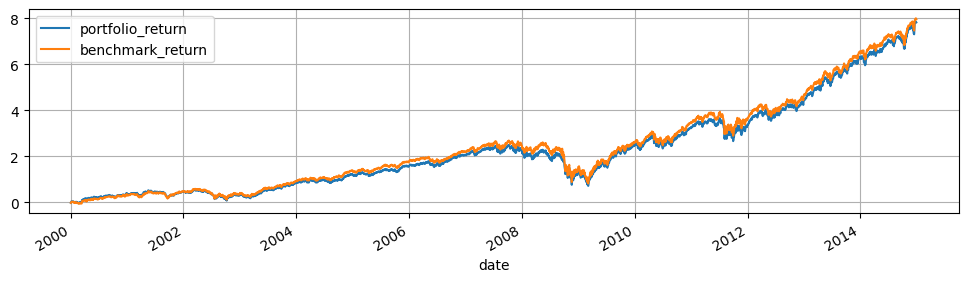

In [13]:
portfolio_performance = pd.DataFrame(pd.DataFrame(returns_df.values*weights_df.values, columns=weights_df.columns, index=weights_df.index).sum(axis=1),columns=['portfolio_return'])[:-2]
daily_returns = portfolio_performance.merge(bmrk,left_index=True,right_index=True,how='left')-1
cumulative_returns = ((daily_returns+1).cumprod()-1)
cumulative_returns.plot(figsize=(12,3))
plt.grid()


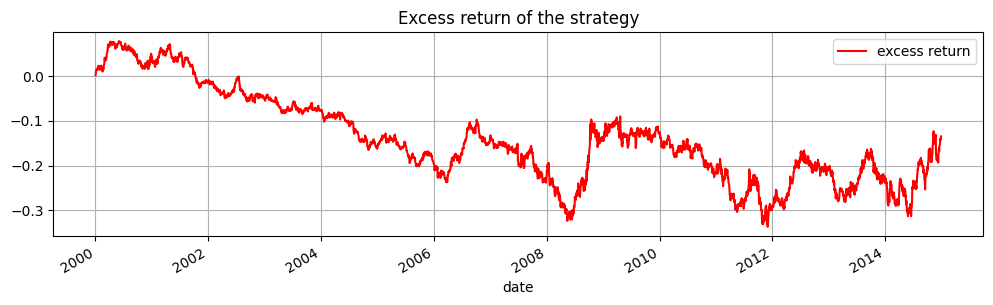

In [14]:
(cumulative_returns['portfolio_return']-cumulative_returns['benchmark_return']).plot(figsize=(12,3),label='excess return',color='r',legend=True)
plt.title('Excess return of the strategy')
plt.grid()


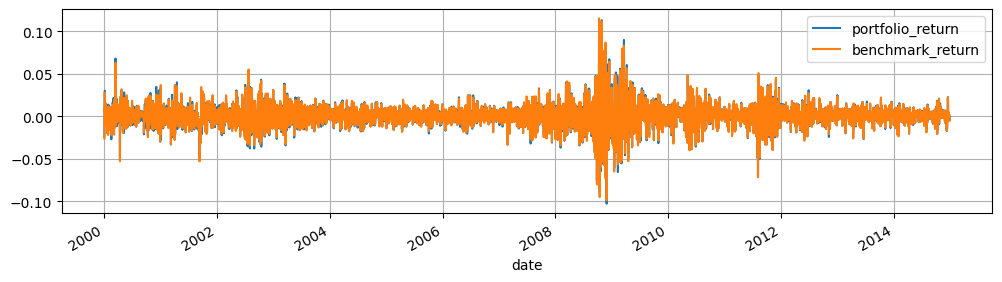

In [15]:
daily_returns.plot(figsize=(12,3))
plt.grid()


### Annualized added value

In [16]:
annualized_return = (1+daily_returns).prod()**(252/len(daily_returns))-1
added_value_annualized = annualized_return['portfolio_return']-annualized_return['benchmark_return']
added_value_annualized


-0.0011742453112109086

### Annualized active risk

In [17]:
excess_return = daily_returns['portfolio_return']-daily_returns['benchmark_return']
active_risk_annualized = excess_return.std()*np.sqrt(252)
active_risk_annualized


0.027961472997762624

### Annualized information ratio
This is the metric used on Kaggle.

In [18]:
information_ratio_annualized = added_value_annualized/active_risk_annualized
information_ratio_annualized


-0.04199511632684256

### Worst relative drawdown

In [19]:
max_seen_so_far = cumulative_returns.cummax()
drawdown = (cumulative_returns-max_seen_so_far)/max_seen_so_far
worst_drawdown = drawdown.min()
relative_worst_drawdown = worst_drawdown['portfolio_return']-worst_drawdown['benchmark_return']
relative_worst_drawdown


1.2371314775711792

### Average number of stocks

In [20]:
average_number_of_stocks = (weights_df>0).sum(axis=1).mean()
average_number_of_stocks


125.0

### Annual turnover rate

In [21]:
turnover_annual = (weights_df.diff().abs().sum(axis=1)/2).mean()*252
turnover_annual


179.1024538442886

## Sanity check
These cells allow you to check if your solution complies with the constraints mentioned in the statement above.

In [22]:
for i,x in enumerate(weights_df.values):

    # Checks you respect the long-only and the cardinality constraint 
    n_positions = sum(x>.0000001)
    assert n_positions==0 or n_positions>=120

    # Checks you do not invest in non existing stocks
    assert (x[np.where(adjusted_close.loc[weights_df.index[i]].isna())]!=0.0).sum()==0
        